In [1]:
# activate Project.toml and download libraries is necessary
using Pkg
Pkg.activate(".")
Pkg.instantiate()

In [2]:
# load project code and external libraries

# definition of trip design task
include("LibTravelPlanner.jl")
using .DaytripDesignAssistance

# generation code for sampling cities and user models
include("TaskGeneration.jl")

# visualization code (don't include this if you don't need it)
include("LibVisualize.jl")

using POMDPs
using MCTS

# Set up the task
We need two things for a trip design task: a city to plan in and a user model which we will assist. This can then be wrapped into an MDP which captures the assistance task itself.

Let's start with generating the city. We need two things: a set of POIs and a home location where the trip must start and end.

In [3]:
# generate a cty of 30 points of interest (POI)
POIs = generate_city(30)

# manually create a home location POI
home = POI(0.1, 0.15, HOME);

Now we can generate a user model. User models are simulators of human reasoning. Two such models exist currently, based on different rationality assumptions: LCUserModel and BoltzmannUserModel. They can be used interchangably.

Let's sample a BoltzmannUserModel. We first sample a UserModelSpecification from the prior provided by TaskGeneration.jl. A UserModelSpecification is an object containing just the parameters of the user model. These allow you to maintain many thousands of user models without creating an excessive memory footprint. Specifications can be instantiated using the "instantiate" function.

In [4]:
# sample a user model specification
tum_spec = sample_spec_from_prior(BoltzmannUserModel)

# instantiate it
true_user_model = instantiate(tum_spec, home, POIs)

  HOME  : (0.1, 0.15)
  #POIs : 30
-------------- PLANNING ------------
  depth                   : 2
  n_iterations            : 500
  exploration             : 0.2
  multi_choice_optimality : 1.2137
  comparison_optimality   : 1.8205
-------------- UTILITY --------------
  category_preferences : [1.0, -0.01509254613149058, 0.6088420272427613, 0.6555213049608937, 0.20329652903692252, 0.0]
  travel_dislike       : 0.1349
  cost_pref_mean       : 166.00
  cost_pref_std        : 6.7495
  cost_weight          : 0.2971


Given a user model we can instantiate an MDP for the planning problem. Let's assume that we know the true user model and use that for planning.

In [5]:
assistanceMDP = DaytripScheduleAssistanceMDP(true_user_model, 0.99); # 0.99 is the discounting rate

The assistance MDP uses the same state space and action space as the user model. Actions are DaytripEdits and come in three types. *ADD* indicates that the POI at *index* within POIs should be added, *REMOVE* indicates that the POI at *index* within the trip should be removed and *NOOP* indicates that nothing should happen.

# Diving into the details

In [6]:
# get initial state
s = initialstate(assistanceMDP).val

actions(assistanceMDP, s)

31-element Vector{DaytripEdit}:
 DaytripEdit(Main.DaytripDesignAssistance.NOOP, 0)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 1)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 2)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 3)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 4)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 5)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 6)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 7)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 8)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 9)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 10)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 11)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 12)
 ⋮
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 19)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 20)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 21)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 22)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 23)
 DaytripEdit(Main.DaytripDesignAssistance.ADD, 24)
 Dayt

States are simply vectors of POIs. In theory the order of the POIs within this vector does not matter but in practive they are put in the order that minimizes the trip lenght.

In [7]:
s

1-element Vector{POI}:
 POI(0.1, 0.15, HOME, 0.0, 0.0)

The state can be visualized with *plot_state*. Obviously the initial state consists of an empty trip so there isn't much to see yet.

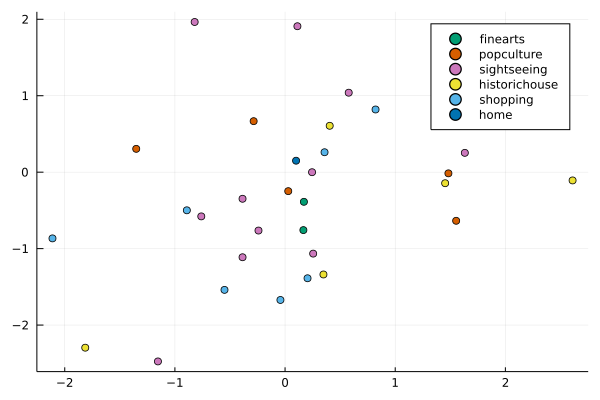

In [8]:
plot_state(s, POIs)

Let's have a look at the user model's policy at state s. We can plot this with *plot_policy*. The user's policy depends on the action that has been recommended to it. Some of the functions support passing *missing* as recommended action, which allows us to simulate how the user would act without assistance.

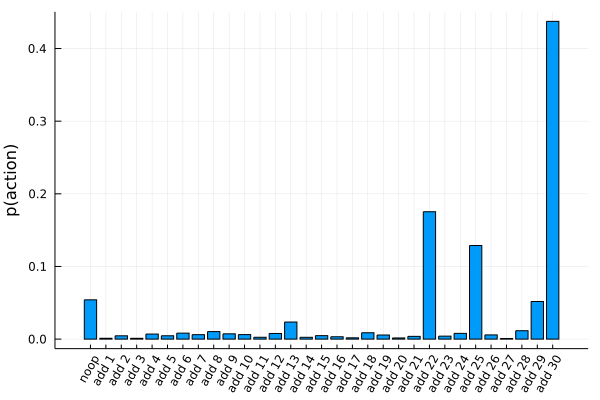

In [9]:
plot_policy(true_user_model, s, missing, condensed = false)
# if there are too many actions to plot you can set condensed = true to hide actions with 0 probability.

# Planning assistance

Let's use MCTS to find an action to recommend. We can do this by simply running one of the MCTS implementations from MCTS.jl on the *assistanceMDP* we defined earlier. For the rollout policy we'll *RecommendOptimal* which is implemented within the DaytripDesignAssistance module.

Note that planning this way is very expensive. The number of iterations done here probably isn't enough to find the optimal recommendation.

In [10]:
solver = DPWSolver(n_iterations = 3000, depth = 3, exploration_constant = 0.2, estimate_value = RolloutEstimator(RecommendOptimal(true_user_model)), show_progress = true)
planner = DPWPlanner(solver, assistanceMDP)

action(planner, s)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


DaytripEdit(Main.DaytripDesignAssistance.ADD, 22)

Let's implement a complete interaction loop by using the RecommendOptimal policy.

In [11]:
assistancePolicy = RecommendOptimal(true_user_model)

states = Array{Daytrip,1}()

s = initialstate(assistanceMDP).val
for iter in 1:10
    push!(states, s)
    
    a = action(assistancePolicy, s) # get AI's recommendation
    s, r, info = gen(assistanceMDP, s, a; optimizer = :LP)
    
    println("""AI recommended to $(string(a)), user chose to $(string(info["user action"])).""")
end

AI recommended to add 30, user chose to add 30.
AI recommended to add 22, user chose to add 22.
AI recommended to add 25, user chose to add 25.
AI recommended to add 29, user chose to add 29.
AI recommended to add 13, user chose to add 8.
AI recommended to add 13, user chose to add 13.
AI recommended to add 18, user chose to noop.
AI recommended to add 18, user chose to noop.
AI recommended to add 18, user chose to noop.
AI recommended to add 18, user chose to noop.


Note hat I have used optimizer = :LP in the call to gen within the interaction loop. For optimizing the ordering of POIs within the state (which is a TSP problem) there are two optimizers implemented: :LP and :CW. :CW is a heuristic and used by default. :LP uses a linear programming solver and therefore returns absolutely optimal solutions but it much slower, too slow for use in planning.

Anywa. Let's visualize the final result.

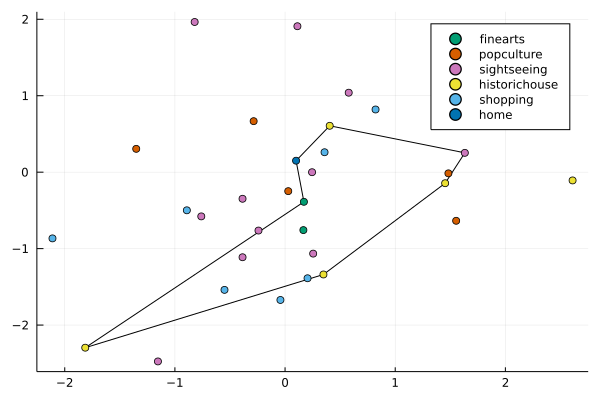

In [12]:
plot_state(s, POIs)

# Some ML focused functionality

You can use the *featurize* function to turn states and user models into vector representations!

In [13]:
featurize(assistanceMDP, s)

30-element Vector{Float32}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 1.0
 ⋮
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 1.0
 1.0

In [14]:
featurize(true_user_model)

13-element Vector{Float32}:
  2.0
  1.2137103
  1.8205653
  1.0
 -0.015092546
  0.608842
  0.65552133
  0.20329653
  0.0
  0.13491969
  0.44996682
  1.6600305
  0.2971266